<a href="https://colab.research.google.com/github/EganStark/CSE475-Lab-Works/blob/main/Final_Ensembling_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


#These are popular ensemble methods used for classification (RandomForestClassifier, GradientBoostingClassifier)
#This is an ensemble model that combines multiple classifiers to
#improve prediction accuracy (VotingClassifier)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

#A simple and widely used
#linear classifier, commonly used as a baseline in classification tasks.

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Used to standardize features by removing the mean and
#scaling to unit variance, which improves model performance(StandardScaler)

#Used to transform categorical data into a numerical format by encoding
#categorical variables as binary (one-hot) vectors(OneHotEncoder)

from sklearn.preprocessing import StandardScaler, OneHotEncoder

#A powerful tool for transforming specific columns in a dataframe,
#often used to apply different preprocessing steps to numerical
#and categorical columns.
from sklearn.compose import ColumnTransformer

#**1. Set Up Google Colab and Import Data**

In [31]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Load dataset from Drive
file_path = '/content/drive/MyDrive/CSE475 Files/cw_22_23_24.csv'  # Update with your file's path
data = pd.read_csv(file_path)

# Display basic information
data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9573 entries, 0 to 9572
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   adm_type    9573 non-null   object
 1   shift_from  9573 non-null   object
 2   ssc         9573 non-null   object
 3   yr_nae      9573 non-null   int64 
 4   m_no        9573 non-null   int64 
 5   mrn         9573 non-null   object
 6   pt_name     9573 non-null   object
 7   sex         9573 non-null   object
 8   disease     7481 non-null   object
 9   D.O.A       9573 non-null   object
 10  D.O.D       9573 non-null   object
 11  status      9573 non-null   object
 12  consultant  9573 non-null   object
 13  L.O.S       9573 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 1.0+ MB


#**Eda**

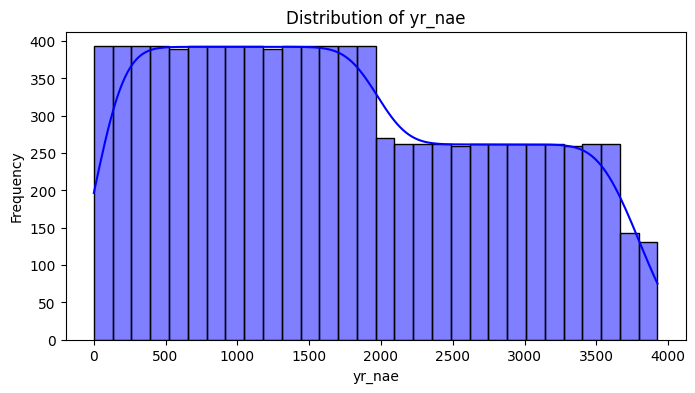

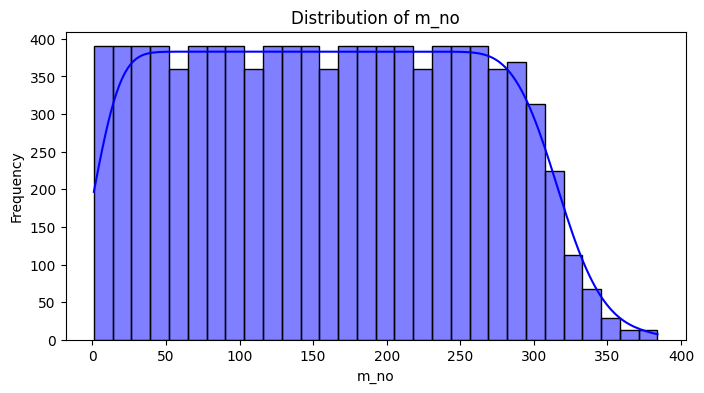

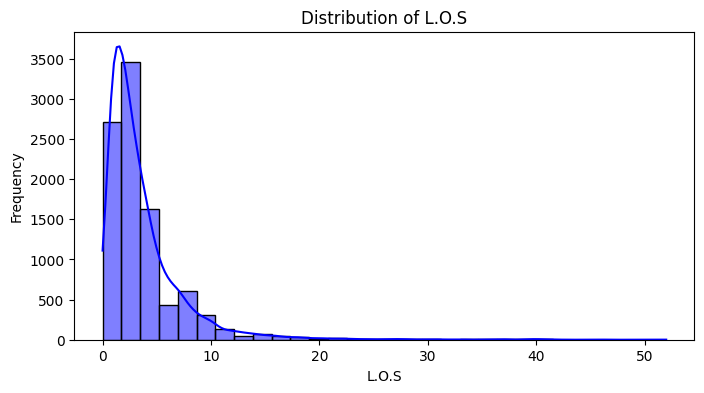

In [33]:
#Distribution of numerical features
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [34]:
# Correlation heatmap for numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


ValueError: could not convert string to float: 'Shift From'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Pairplot for relationships between features
selected_columns = numerical_columns[:5]  # Select the first 5 numerical columns for pairplot
sns.pairplot(data[selected_columns])
plt.show()


In [ ]:
# Boxplots for outlier detection
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col], palette="Set2")
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

#**2. Data Preprocessing**

In [35]:
# Check for missing values in each column
print("\nMissing Values Count:")
print(data.isnull().sum())
# Calculate percentage of missing values
missing_percentage = (data.isnull().sum() / len(data)) * 100
print("\nPercentage of Missing Values:")
print(missing_percentage)


Missing Values Count:
adm_type         0
shift_from       0
ssc              0
yr_nae           0
m_no             0
mrn              0
pt_name          0
sex              0
disease       2092
D.O.A            0
D.O.D            0
status           0
consultant       0
L.O.S            0
dtype: int64

Percentage of Missing Values:
adm_type       0.000000
shift_from     0.000000
ssc            0.000000
yr_nae         0.000000
m_no           0.000000
mrn            0.000000
pt_name        0.000000
sex            0.000000
disease       21.853129
D.O.A          0.000000
D.O.D          0.000000
status         0.000000
consultant     0.000000
L.O.S          0.000000
dtype: float64


In [36]:
# Identify categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

print("\nCategorical Columns:", categorical_columns)
print("\nNumerical Columns:", numerical_columns)



Categorical Columns: Index(['adm_type', 'shift_from', 'ssc', 'mrn', 'pt_name', 'sex', 'disease',
       'D.O.A', 'D.O.D', 'status', 'consultant'],
      dtype='object')

Numerical Columns: Index(['yr_nae', 'm_no', 'L.O.S'], dtype='object')


In [37]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Apply Label Encoding to each categorical column
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col].astype(str))  # Ensure all values are strings

print("\nEncoded Categorical Columns:")
print(data.head())


Encoded Categorical Columns:
   adm_type  shift_from  ssc  yr_nae  m_no  mrn  pt_name  sex  disease  D.O.A  \
0         4          35    0       1     1   20     2068    0      623     10   
1         4          35    0       2     2   25     5938    1       25     10   
2         4          35    0       3     3   18      905    1      783     10   
3         4          35    0       4     4   27      523    0      806     10   
4         4          69    0       5     5   15     2697    0      806     10   

   D.O.D  status  consultant  L.O.S  
0     10       1           6      0  
1    768       1           8      4  
2     41       1           4      9  
3    830       1          12      6  
4    339       1          14      1  


In [38]:
# Replace missing values with the mean for numerical columns
for col in numerical_columns:
    if data[col].isnull().sum() > 0:  # Only apply to columns with missing values
        data[col] = data[col].fillna(data[col].mean())

print("\nMissing Values After Replacement:")
print(data.isnull().sum())


Missing Values After Replacement:
adm_type      0
shift_from    0
ssc           0
yr_nae        0
m_no          0
mrn           0
pt_name       0
sex           0
disease       0
D.O.A         0
D.O.D         0
status        0
consultant    0
L.O.S         0
dtype: int64


In [39]:
# Display updated dataset information
print("\nUpdated Dataset Info:")
print(data.info())

# Display the first few rows of the updated dataset
print("\nFirst 5 Rows of Updated Dataset:")
print(data.head())



Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9573 entries, 0 to 9572
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   adm_type    9573 non-null   int64
 1   shift_from  9573 non-null   int64
 2   ssc         9573 non-null   int64
 3   yr_nae      9573 non-null   int64
 4   m_no        9573 non-null   int64
 5   mrn         9573 non-null   int64
 6   pt_name     9573 non-null   int64
 7   sex         9573 non-null   int64
 8   disease     9573 non-null   int64
 9   D.O.A       9573 non-null   int64
 10  D.O.D       9573 non-null   int64
 11  status      9573 non-null   int64
 12  consultant  9573 non-null   int64
 13  L.O.S       9573 non-null   int64
dtypes: int64(14)
memory usage: 1.0 MB
None

First 5 Rows of Updated Dataset:
   adm_type  shift_from  ssc  yr_nae  m_no  mrn  pt_name  sex  disease  D.O.A  \
0         4          35    0       1     1   20     2068    0      623     10   
1     

In [40]:

# Define features and target variable (e.g., predicting 'status')
X = data.drop(columns=['status'])
y = data['status']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Display the processed data
X_train.head(), y_train.head()

(      adm_type  shift_from  ssc  yr_nae  m_no   mrn  pt_name  sex  disease  \
 4228         4          35    1     554   240  4264     3694    1      461   
 3524         4          35    0    3525   164  3570      473    0      806   
 6418         4          35    1    2744   150  6384     6487    0       73   
 2492         4          10    0    2493    43  2239     5292    0      254   
 6271         4          35    1    2596     3  6257     1854    1       73   
 
       D.O.A  D.O.D  consultant  L.O.S  
 4228    457    606           6      5  
 3524    214    367           8      4  
 6418    178    271           6      3  
 2492    787    119          10      7  
 6271     29    819           4      5  ,
 4228    1
 3524    1
 6418    1
 2492    1
 6271    1
 Name: status, dtype: int64)

#**3. Implement Ensemble Learning Techniques**

**3.1 Bagging: Random Forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest Classifier Initialization
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Model
rf_model.fit(X_train, y_train)

# Making Predictions
rf_predictions = rf_model.predict(X_test)

# Evaluating the Model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

# Generate Classification Report
rf_report = classification_report(y_test, rf_predictions)
print("Classification Report for Random Forest:\n", rf_report)


Random Forest Accuracy: 0.8971279373368146
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.90      1.00      0.95      1722
           2       0.25      0.01      0.02       112
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        32

    accuracy                           0.90      1915
   macro avg       0.23      0.20      0.19      1915
weighted avg       0.82      0.90      0.85      1915



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**3.2 Boosting: XGBoost**

In [42]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.90      0.99      0.94      1722
           2       0.17      0.02      0.03       112
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        32

    accuracy                           0.89      1915
   macro avg       0.21      0.20      0.20      1915
weighted avg       0.82      0.89      0.85      1915



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# Evaluate XGBoost
xgb_accuracy = accuracy_score(y_test, y_pred_xgb) # Changed xgb_predictions to y_pred_xgb
print("XGBoost Accuracy:", xgb_accuracy)


XGBoost Accuracy: 0.8945169712793734


**3.3 Stacking**

In [44]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define meta-learner (Logistic Regression)
meta_learner = LogisticRegression()

# Set up the stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
stacking_predictions = stacking_model.predict(X_test)

# Evaluate the stacking model
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print("Stacking Model Accuracy:", stacking_accuracy)

# Generate Classification Report
stacking_report = classification_report(y_test, stacking_predictions)
print("Classification Report for Stacking Model:\n", stacking_report)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:05:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:05:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:05:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:05:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:05:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Stacking Model Accuracy: 0.8986945169712793
Classification Report for Stacking Model:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.90      1.00      0.95      1722
           2       0.00      0.00      0.00       112
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        32

    accuracy                           0.90      1915
   macro avg       0.18      0.20      0.19      1915
weighted avg       0.81      0.90      0.85      1915



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**3.5 Voting**

In [45]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
    ],
    voting='soft'  # Use soft voting for probability averaging
)

# Train the Voting Classifier
voting_classifier.fit(X_train, y_train)

# Make predictions
voting_predictions = voting_classifier.predict(X_test)

# Evaluate Voting Classifier
voting_accuracy = accuracy_score(y_test, voting_predictions)
print("Voting Classifier Accuracy:", voting_accuracy)

# Generate Classification Report
voting_report = classification_report(y_test, voting_predictions)
print("Classification Report for Voting Classifier:\n", voting_report)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:06:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 0.8955613577023499
Classification Report for Voting Classifier:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.90      1.00      0.95      1722
           2       0.12      0.01      0.02       112
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        32

    accuracy                           0.90      1915
   macro avg       0.21      0.20      0.19      1915
weighted avg       0.82      0.90      0.85      1915



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
# Evaluate Stacking Model
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print("Stacking Model Accuracy:", stacking_accuracy)

# Evaluate Voting Classifier
voting_accuracy = accuracy_score(y_test, voting_predictions)
print("Voting Classifier Accuracy:", voting_accuracy)


Stacking Model Accuracy: 0.8986945169712793
Voting Classifier Accuracy: 0.8955613577023499


**Combine multiple classifiers by voting.**

In [47]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the Voting Classifier with XGBoost and Random Forest
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
    ],
    voting='soft'  # Use soft voting to average probabilities
)

# Train the Voting Classifier
voting_classifier.fit(X_train, y_train)

# Make predictions
voting_predictions = voting_classifier.predict(X_test)

# Evaluate the Voting Classifier
voting_accuracy = accuracy_score(y_test, voting_predictions)
print("Voting Classifier Accuracy:", voting_accuracy)

# Generate Classification Report
voting_report = classification_report(y_test, voting_predictions)
print("Classification Report for Voting Classifier:\n", voting_report)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:06:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 0.8955613577023499
Classification Report for Voting Classifier:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.90      1.00      0.95      1722
           2       0.12      0.01      0.02       112
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        32

    accuracy                           0.90      1915
   macro avg       0.21      0.20      0.19      1915
weighted avg       0.82      0.90      0.85      1915



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Evaluation**

In [48]:
# Summary of Accuracy Results
print("Summary of Accuracy Results:")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"Stacking Model Accuracy: {stacking_accuracy:.4f}")
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")



Summary of Accuracy Results:
Random Forest Accuracy: 0.8971
XGBoost Accuracy: 0.8945
Stacking Model Accuracy: 0.8987
Voting Classifier Accuracy: 0.8956


#**4. Apply Cross-Validatio**n

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define the models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Perform cross-validation for each model
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
cv_scores_stacking = cross_val_score(stacking_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Random Forest CV Scores:", cv_scores_rf)
print("XGBoost CV Scores:", cv_scores_xgb)
print("Stacking Model CV Scores:", cv_scores_stacking)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:09:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:09:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:09:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:09:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:09:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Random Forest CV Scores: [0.45691906 0.86370757 0.89869452 0.57419018 0.53134796]
XGBoost CV Scores: [0.26997389 0.69556136 0.87415144 0.21525601 0.70532915]
Stacking Model CV Scores: [0.89921671 0.89921671 0.89921671 0.89916405 0.89916405]


In [53]:
# Adjust PCA to use the maximum available number of features
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Adjusting XGBoost parameters for faster execution
xgb_model_optimized = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=50,  # Reduced number of trees
    max_depth=3,  # Limiting the depth of each tree
    learning_rate=0.1  # Default learning rate
)

# Change n_components to be less than or equal to the number of features
pca = PCA(n_components=8)  # Or any value between 0 and 8, inclusive
X_reduced = pca.fit_transform(X)

# Re-run cross-validation for optimized XGBoost on reduced data
cv_scores_xgb_reduced = cross_val_score(xgb_model_optimized, X_reduced, y, cv=5, scoring='accuracy')


# Re-run cross-validation for optimized XGBoost on reduced data
cv_scores_xgb_reduced = cross_val_score(xgb_model_optimized, X_reduced, y, cv=5, scoring='accuracy')

# Document the cross-validation results for PCA-reduced XGBoost
xgb_reduced_cv_mean = np.mean(cv_scores_xgb_reduced)
xgb_reduced_cv_std = np.std(cv_scores_xgb_reduced)

xgb_reduced_cv_mean, xgb_reduced_cv_std, cv_scores_xgb_reduced

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:12:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

(0.7778276871533377,
 0.17605509940248082,
 array([0.42976501, 0.86005222, 0.89921671, 0.88087774, 0.81922675]))

**Visualizing Cross-Validation Results**

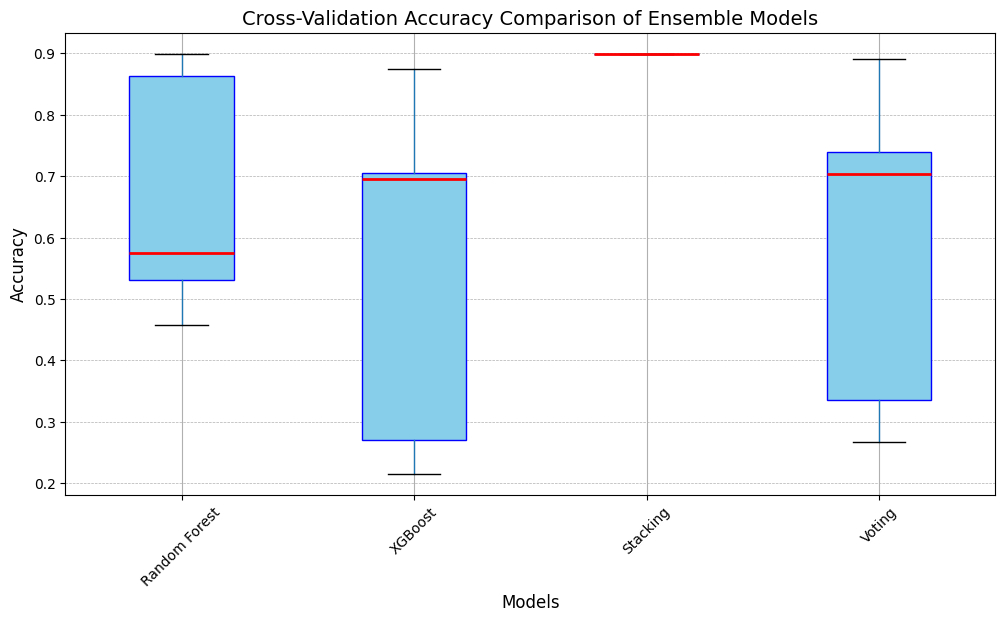

Summary Statistics for Cross-Validation Results:
       Random Forest   XGBoost  Stacking    Voting
count       5.000000  5.000000  5.000000  5.000000
mean        0.664972  0.552054  0.899196  0.587367
std         0.202179  0.291906  0.000029  0.271655
min         0.456919  0.215256  0.899164  0.266319
25%         0.531348  0.269974  0.899164  0.335946
50%         0.574190  0.695561  0.899217  0.704284
75%         0.863708  0.705329  0.899217  0.739426
max         0.898695  0.874151  0.899217  0.890862


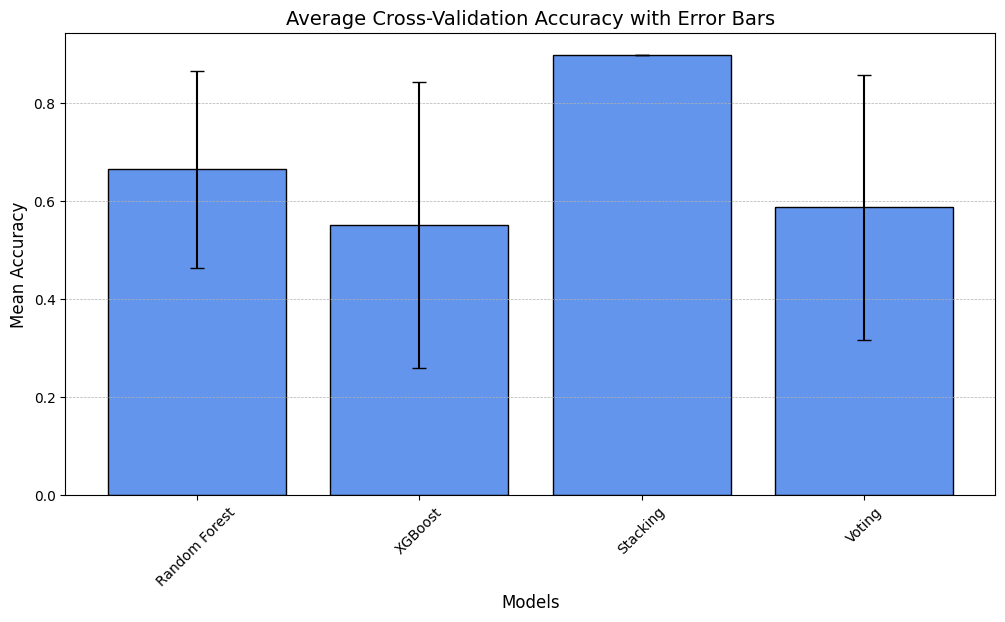

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert cross-validation results into a pandas DataFrame
results_df = pd.DataFrame(results)

# Plot box plot for cross-validation accuracy comparison
plt.figure(figsize=(12, 6))
results_df.boxplot(
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", color="blue"),
    medianprops=dict(color="red", linewidth=2)
)
plt.title("Cross-Validation Accuracy Comparison of Ensemble Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.show()

# Summary statistics for visualization
print("Summary Statistics for Cross-Validation Results:")
summary_stats = results_df.describe()
print(summary_stats)

# Plot average accuracy with error bars (mean ± std deviation)
plt.figure(figsize=(12, 6))
mean_accuracy = results_df.mean()
std_accuracy = results_df.std()

# Bar plot with error bars
plt.bar(mean_accuracy.index, mean_accuracy, yerr=std_accuracy, capsize=5, color="cornflowerblue", edgecolor="black")
plt.title("Average Cross-Validation Accuracy with Error Bars", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.show()

# Check for perfect accuracy
perfect_accuracy_models = results_df.columns[(results_df.max() >= 1.0)].tolist()
if perfect_accuracy_models:
    print(f"Warning: Models with perfect accuracy detected: {perfect_accuracy_models}")
    print("This may indicate overfitting or an overly simple dataset.")


**Confusion Matrix for Each Model**

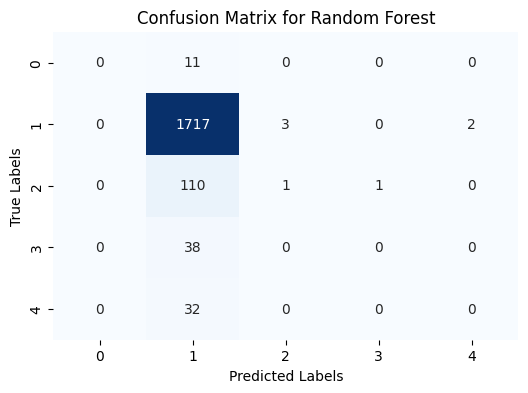

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


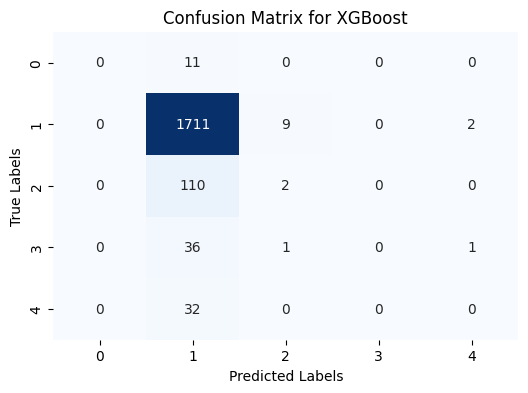

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

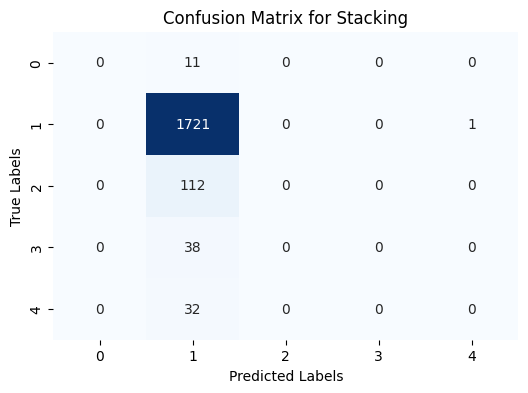

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


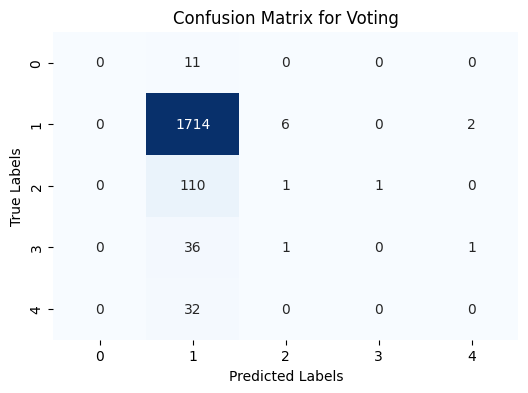

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define models
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Stacking": stacking_model,
    "Voting": voting_classifier
}

# Fit each model on the training data and plot the confusion matrix for each
for model_name, model in models.items():
    # Fit the model and predict on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Initialize a list to collect metrics
metrics_summary = []

# Define models
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Stacking": stacking_model,
    "Voting": voting_classifier
}

# Evaluate each model and collect metrics
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Append metrics to the list
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the summary
print("Model Performance Summary:")
print(metrics_df)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:17:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:17:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:17:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:17:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model Performance Summary:
           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.897128   0.829566  0.897128  0.851672
1        XGBoost  0.894517   0.845103  0.894517  0.851450
2       Stacking  0.898695   0.892616  0.898695  0.851239
3         Voting  0.895561   0.822964  0.895561  0.851324


#**5. Explainable AI (XAI)**

**5.1 SHAP**

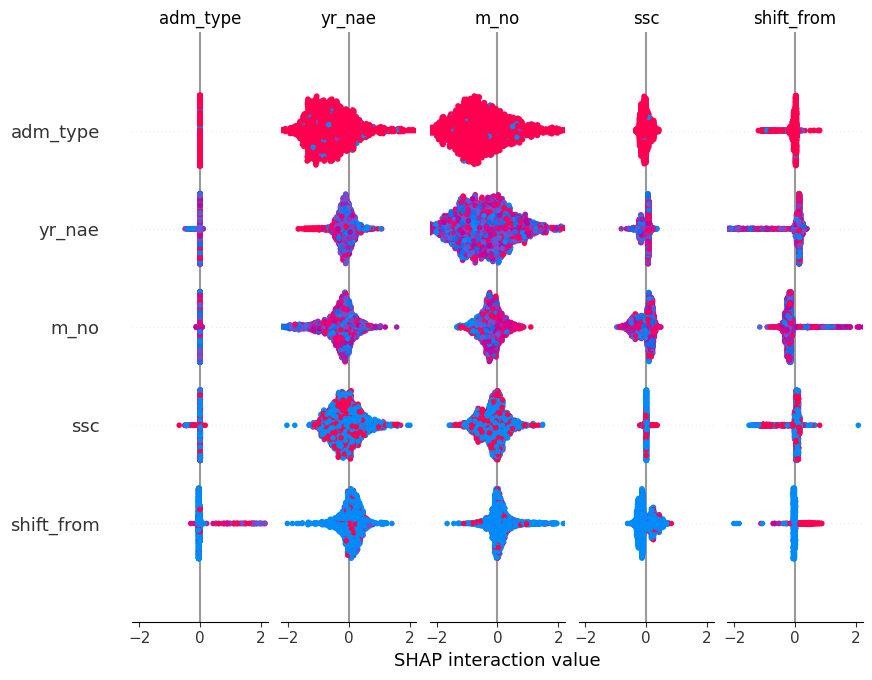

In [61]:
import shap

# Ensure XGBoost is trained
xgb.fit(X_train, y_train)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

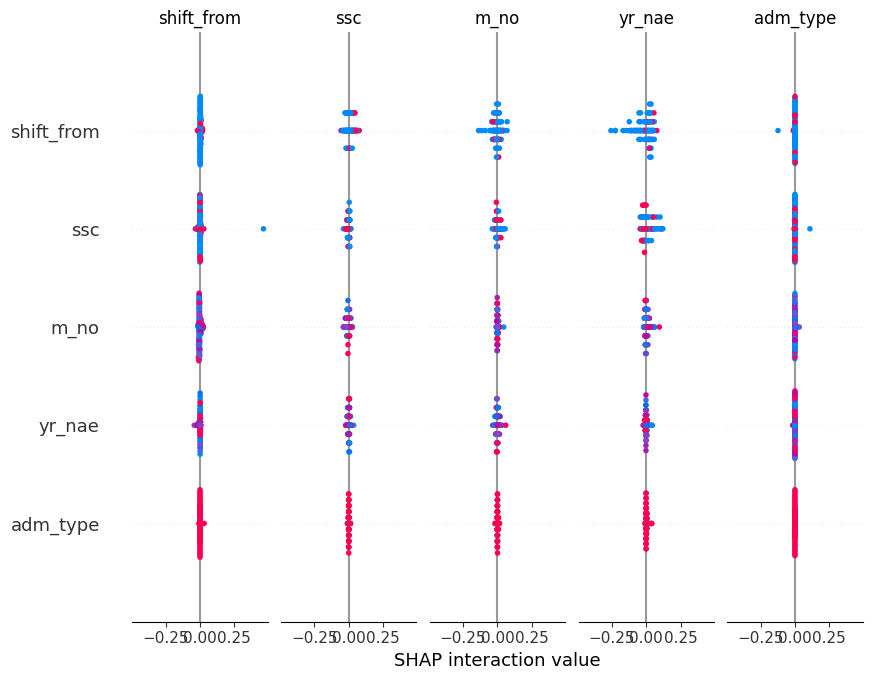

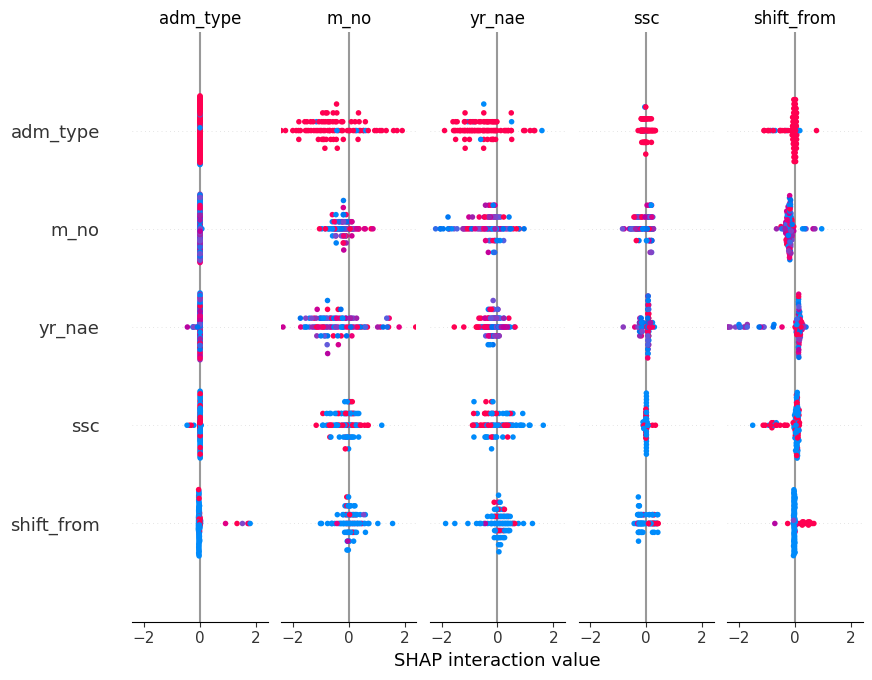

In [58]:
import shap

# Use a subset of the test data for SHAP to reduce computation time
X_sample = X_test.sample(100, random_state=42)

# Initialize SHAP explainer for the Random Forest model
rf_explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the Random Forest model
rf_shap_values = rf_explainer.shap_values(X_sample)

# Display the first SHAP summary plot for Random Forest
shap.summary_plot(rf_shap_values[1] if isinstance(rf_shap_values, list) else rf_shap_values,
                  X_sample,
                  plot_type="bar",
                  feature_names=X_sample.columns)

# SHAP for XGBoost
xgb_explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the XGBoost model
xgb_shap_values = xgb_explainer.shap_values(X_sample)

# Display the SHAP summary plot for XGBoost
shap.summary_plot(xgb_shap_values[1] if isinstance(xgb_shap_values, list) else xgb_shap_values,
                  X_sample,
                  plot_type="bar",
                  feature_names=X_sample.columns)


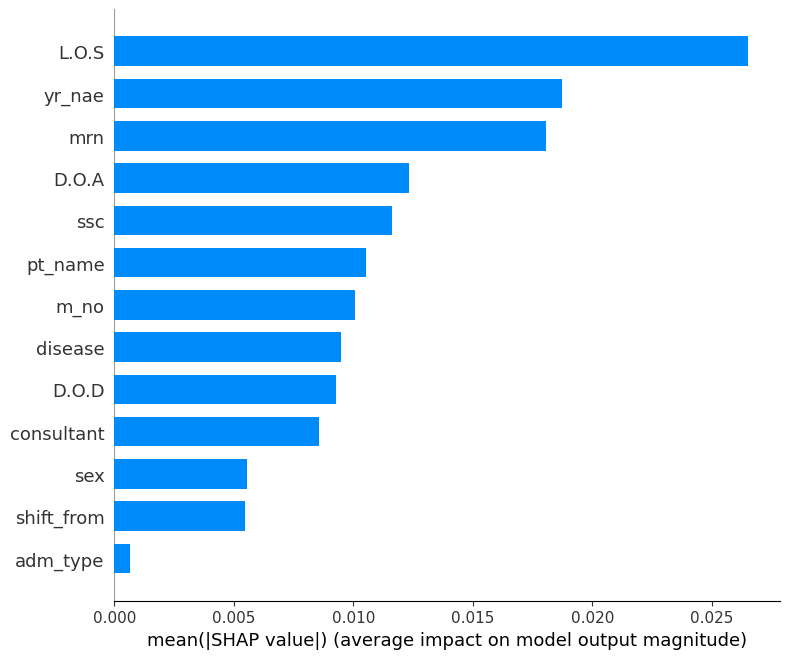

Shape of SHAP values: (1915, 13)
Shape of X_test: (1915, 13)
Feature names in X_test: Index(['adm_type', 'shift_from', 'ssc', 'yr_nae', 'm_no', 'mrn', 'pt_name',
       'sex', 'disease', 'D.O.A', 'D.O.D', 'consultant', 'L.O.S'],
      dtype='object')


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [59]:
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier

# Assuming you have X_train and y_train for training data
rf = RandomForestClassifier(random_state=42)  # Initialize the model
rf.fit(X_train, y_train)  # Fit the model to your training data

# Initialize SHAP explainer
shap_explainer = shap.TreeExplainer(rf)
shap_values = shap_explainer.shap_values(X_test)

# Initialize SHAP explainer
shap_explainer = shap.TreeExplainer(rf)
shap_values = shap_explainer.shap_values(X_test)
# Check if the model is multiclass by inspecting the shape of shap_values
if len(shap_values.shape) > 2:  # Multiclass if shape is (n_samples, n_features, n_classes)
    # Choose the SHAP values for a specific class, e.g., class 1
    class_index = 1  # Adjust based on the class you want to analyze
    shap_values_class = shap_values[:, :, class_index] # Select SHAP values for the specific class
    shap.summary_plot(shap_values_class, X_test, plot_type="bar")
else:
    # Binary classification
    shap.summary_plot(shap_values, X_test, plot_type="bar")

# Now you can safely access shap_values_class for multiclass cases
print("Shape of SHAP values:", shap_values_class.shape)
print("Shape of X_test:", X_test.shape)
print("Feature names in X_test:", X_test.columns)


# Summary plot for SHAP values to show feature importance
# Select SHAP values for the desired class (index 1) for this plot as well
shap_values_class_1 = shap_values[1]
shap.summary_plot(shap_values[class_index], X_test, plot_type="bar")

# Check if SHAP returned a list (multiclass case)
if isinstance(shap_values, list):
    class_index = 1  # Select class index, e.g., 1
    shap_values_class = shap_values[class_index]

    # Ensure feature alignment
    X_test = X_test[rf_model.feature_names_in_]

    # Check shapes
    print("Shape of SHAP values:", shap_values_class.shape)
    print("Shape of X_test:", X_test.shape)

    # Plot SHAP summary
    shap.summary_plot(shap_values_class, X_test, plot_type="bar")
else:
    # Binary classification
    shap.summary_plot(shap_values, X_test, plot_type="bar")

**5.2 LIME**

In [62]:
!pip install lime

In [63]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),  # Use the feature names from the training data
    class_names=[str(cls) for cls in y.unique()],  # Convert target classes to string format
    mode='classification'
)

# Choose a sample from the test set to explain
sample_index = 0  # Adjust the index to analyze a different sample

# Generate the explanation for the chosen test instance using Random Forest
exp = lime_explainer.explain_instance(
    X_test.values[sample_index],
    rf_model.predict_proba,  # Use the predict_proba method of the Random Forest model
    num_features=10  # Show the top 10 features contributing to the prediction
)

# Display the explanation
exp.show_in_notebook()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [74]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import display, HTML

# Ensure the XGBoost model is trained
xgb_model.fit(X_train, y_train)

# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),  # Use the feature names from the training data
    class_names=[str(cls) for cls in y_train.unique()],  # Ensure class names are strings
    mode='classification',
    verbose=True,
    discretize_continuous=True
)

# Explain a single instance from the test set
sample_index = 0  # Index of the instance to explain
lime_exp = lime_explainer.explain_instance(
    X_test.iloc[sample_index].values,  # Instance to explain
    xgb_model.predict_proba,  # Predict probabilities using the XGBoost model
    num_features=10  # Number of top features to show
)

# Render explanation as HTML and apply custom styling
html_explanation = lime_exp.as_html()
custom_style = """
<style>
    body {
        background-color: white !important;
        color: black !important;
    }
    table {
        background-color: white !important;
    }
</style>
"""
display(HTML(custom_style + html_explanation))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:39:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Intercept 0.8688226984212146
Prediction_local [1.04349544]
Right: 0.9676765


**6. Performance Analysis**

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'rf_model' is your trained Random Forest model and 'X_test' is your test data
y_pred_rf = rf_model.predict(X_test) # Generate predictions using the Random Forest model

# Example for Random Forest
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")


Accuracy: 0.8971279373368146
Precision: 0.8238221915693712
Recall: 0.8971279373368146
F1 Score: 0.851672335292984


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x600 with 0 Axes>

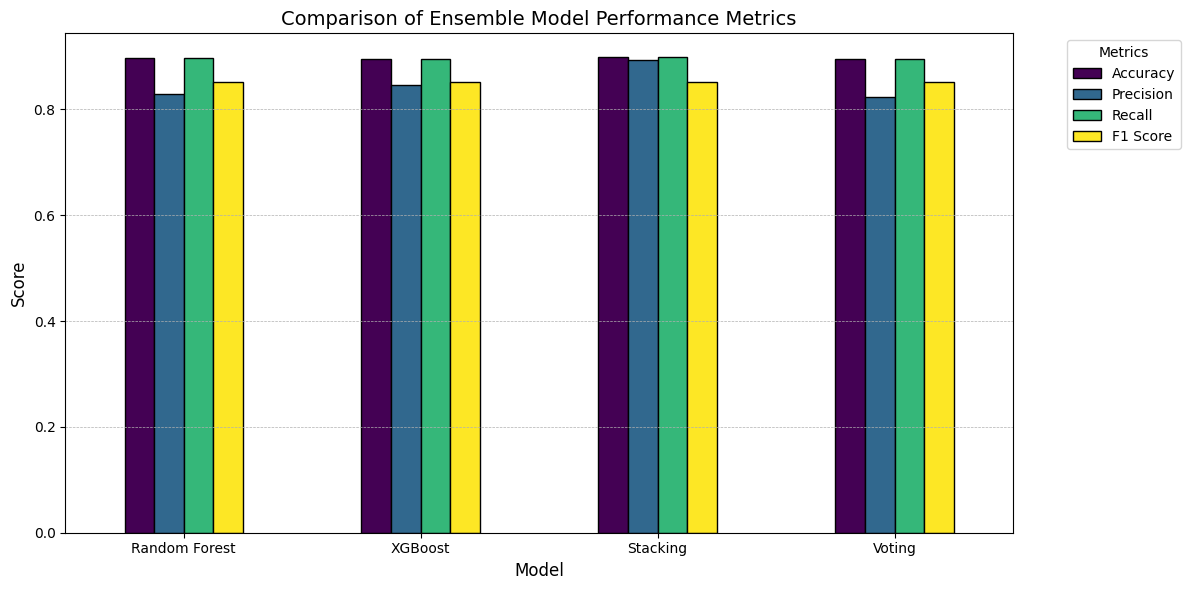

In [72]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert metrics summary into a DataFrame if not already done
if 'metrics_summary' in locals():
    metrics_df = pd.DataFrame(metrics_summary)
else:
    raise ValueError("Ensure metrics_summary exists and contains model performance data.")

# Auto-detect and include model names in the DataFrame
if 'Model' not in metrics_df.columns:
    raise ValueError("The 'Model' column must be included in the metrics_summary.")

# Set the Model column as the index for plotting
metrics_df.set_index("Model", inplace=True)

# Plot the bar plot for model comparison
plt.figure(figsize=(12, 6))
metrics_df.plot(kind="bar", figsize=(12, 6), edgecolor="black", colormap="viridis")
plt.title("Comparison of Ensemble Model Performance Metrics", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
